
From Kaggle: 
"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

### Pytorch Advantages vs Tensorflow
- Pytorch Enables dynamic computational graphs (which change be changed) while Tensorflow is static. 
- Tensorflow enables easier deployment. 

In [4]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [5]:
#define the training parameters
batch_size=32
test_batch_size=32
epochs=50  #The number of Epochs is the number of times you go through the full dataset. 
lr=1.0 #Learning rate is how fast it will decend. 

seed=1 #random seed
log_interval=500 #log data about statics
cuda=True #use gpu training


In [6]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [40]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self , activation='relu'):
        super(Net, self).__init__()
        self.img_size = 28*28
        self.fc1 = nn.Linear(self.img_size, 512)          # fully connected layer 1
        self.fc2 = nn.Linear(512, 512 )                   # fully connected layer 2
        self.fc3 = nn.Linear(512,512 )                     # fully connected layer 3
        self.fc4 = nn.Linear(512, 512 )                   # fully connected layer 4
        self.fc5 = nn.Linear(512, 512 )                    # fully connected layer 5
        self.fc6 = nn.Linear(512, 512)                    # fully conncted layer 6 
        self.out_layer = nn.Linear(512,10)                # output layer
        #select the activation function
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        if(activation=='logistic_sigmoid'):
            self.activation_fn = nn.LogSigmoid()

    def forward(self, x):
        #flatten the input vector
        x = x.view(-1, self.img_size)
        #Linear Layer 1 /Activation
        x = self.activation_fn( self.fc1(x) ) 
        #Linear Layer 2 /Activation
        x = self.activation_fn( self.fc2(x) ) 
        #Linear Layer 3 /Activation
        x = self.activation_fn( self.fc3(x) ) 
        #Linear Layer 4 /Activation
        x = self.activation_fn( self.fc4(x) ) 
        #Linear Layer 5 /Activation
        x = self.activation_fn( self.fc5(x) ) 
        #Linear Layer 5 /Activation
        x = self.activation_fn( self.fc6(x) ) 
        out = self.out_layer(x)
        #Softmax gets probabilities. 
        return F.log_softmax(out, dim=1)

#model weight initialization function 
def init_weights_normal(m):
    if type(m) == nn.Linear:
    
        torch.nn.init.normal_(m.weight , mean=0 , std=0.01)
        m.bias.data.fill_(0.01)

def init_weights_xavier(m):
    if type(m) == nn.Linear:      
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
def init_weights_kaiman(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [41]:
#training the model
def train(epoch , model , optimizer):
    model_test_accuracy = []
    model.train()
    for i_epoch in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            #Variables in Pytorch are differenciable. 
            data, target = Variable(data), Variable(target)
            #This will zero out the gradients for this batch. 
            optimizer.zero_grad()
            output = model(data)
            # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
            loss = F.nll_loss(output, target)
            #dloss/dx for every Variable 
            loss.backward()
            #to do a one-step update on our parameter.
            optimizer.step()
            #Print out the loss periodically. 
            if((i_epoch+1)%10==0):
                if batch_idx % log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        i_epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.detach().item()))
            

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = data, target
                output = model(data)
                test_loss += F.nll_loss(output, target).detach().item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

            test_loss /= len(test_loader.dataset)
            if((i_epoch+1)%10==0):
                print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    test_loss, correct, len(test_loader.dataset),
                    100. * correct / len(test_loader.dataset)))
        
        model.train()

        model_test_accuracy.append(100. * correct / len(test_loader.dataset))
    return model_test_accuracy

# Model 1 Training

In [9]:
device="cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
# --------------------------> activation = logistic sigmoid | init_method=random normal
model1 = Net(activation='logistic_sigmoid')
model1.apply(init_weights_normal)
if cuda:
    model1.to(device)
optimizer_sgd = optim.SGD(model1.parameters(), lr=lr)

#SGD Training

test_SGD_accuracy = train(epochs , model1 , optimizer_sgd)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 9 [0/60000 (0%)]	Loss: 2.297875
Train Epoch: 9 [16000/60000 (27%)]	Loss: 2.305067
Train Epoch: 9 [32000/60000 (53%)]	Loss: 2.316880
Train Epoch: 9 [48000/60000 (80%)]	Loss: 2.317471

Test set: Average loss: 1.8036, Accuracy: 3180/10000 (32%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 2.305707
Train Epoch: 19 [16000/60000 (27%)]	Loss: 2.295286
Train Epoch: 19 [32000/60000 (53%)]	Loss: 2.327022
Train Epoch: 19 [48000/60000 (80%)]	Loss: 2.307549

Test set: Average loss: 2.3099, Accuracy: 1028/10000 (10%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 2.308360
Train Epoch: 29 [16000/60000 (27%)]	Loss: 2.311817
Train Epoch: 29 [32000/60000 (53%)]	Loss: 2.302921
Train Epoch: 29 [48000/60000 (80%)]	Loss: 2.308297

Test set: Average loss: 2.3146, Accuracy: 1028/10000 (10%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 2.318058
Train Epoch: 39 [16000/60000 (27%)]	Loss: 2.285443
Train Epoch: 39 [32000/60000 (53%)]	Loss: 2.334982
Train Epoch: 39 [48000/60000 (80%)]	Loss: 2.339908

Test set: Average loss: 

In [11]:
# --------------------------> activation = logistic sigmoid | init_method=random normal
model1 = Net(activation='logistic_sigmoid')
model1.apply(init_weights_normal)

if cuda:
    model1.cuda()
optimizer_adam = optim.Adam(model1.parameters())
#Adam Training

test_ADAM_accuracy  = train(epochs ,model1 ,  optimizer_adam)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Train Epoch: 9 [0/60000 (0%)]	Loss: 0.002295
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.000934
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000324
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.009001

Test set: Average loss: 0.0905, Accuracy: 9801/10000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.024684
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.006349
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.000308
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000022

Test set: Average loss: 0.1317, Accuracy: 9826/10000 (98%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.027656
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.018141
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.000011
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.003959

Test set: Average loss: 0.3272, Accuracy: 9770/10000 (98%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.001823
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.181753
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.014702
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.000000

Test set: Average loss: 

# Model 2 Training

In [12]:
# --------------------------> activation = logistic sigmoid  | init_method=xavier
model2 = Net(activation='logistic_sigmoid')
model2.apply(init_weights_xavier)
if cuda:
    model2.cuda()
optimizer_sgd = optim.SGD(model2.parameters(), lr=lr)
#SGD Training

model2_SGD_accuracy = train(epochs , model2 , optimizer_sgd)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Train Epoch: 9 [0/60000 (0%)]	Loss: nan
Train Epoch: 9 [16000/60000 (27%)]	Loss: nan
Train Epoch: 9 [32000/60000 (53%)]	Loss: nan
Train Epoch: 9 [48000/60000 (80%)]	Loss: nan

Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Train Epoch: 19 [0/60000 (0%)]	Loss: nan
Train Epoch: 19 [16000/60000 (27%)]	Loss: nan
Train Epoch: 19 [32000/60000 (53%)]	Loss: nan
Train Epoch: 19 [48000/60000 (80%)]	Loss: nan

Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Train Epoch: 29 [0/60000 (0%)]	Loss: nan
Train Epoch: 29 [16000/60000 (27%)]	Loss: nan
Train Epoch: 29 [32000/60000 (53%)]	Loss: nan
Train Epoch: 29 [48000/60000 (80%)]	Loss: nan

Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Train Epoch: 39 [0/60000 (0%)]	Loss: nan
Train Epoch: 39 [16000/60000 (27%)]	Loss: nan
Train Epoch: 39 [32000/60000 (53%)]	Loss: nan
Train Epoch: 39 [48000/60000 (80%)]	Loss: nan

Test set: Average loss: nan, Accuracy: 980/10000 (10%)

Train Epoch: 49 [0/60000 (0%)]	Loss: nan
Train Epoch: 49 [16

In [50]:
# --------------------------> activation = logistic sigmoid  | init_method=xavier
model2 = Net(activation='logistic_sigmoid')
model2.apply(init_weights_xavier)
if cuda:
    model2.cuda()
optimizer_adam = optim.Adam(model2.parameters())
#Adam Training

model2_ADAM_accuracy  = train(epochs ,model2 ,  optimizer_adam)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000011
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.029091
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000455
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.001898

Test set: Average loss: 0.0042, Accuracy: 9772/10000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.000028
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.001514
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.373095
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000089

Test set: Average loss: 0.0055, Accuracy: 9800/10000 (98%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000007
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.001050
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.000252
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.000000

Test set: Average loss: 0.0102, Accuracy: 9805/10000 (98%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.005932
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.000000
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.000085
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.000000

Test set: Average loss: 

# Model 3 Training

In [46]:
# --------------------------> activation =relu  | init_method=random normal
model3 = Net(activation='relu')
model3.apply(init_weights_normal)
if cuda:
    model3.cuda()
optimizer_sgd = optim.SGD(model3.parameters(), lr=0.02 )
#SGD Training

model3_SGD_accuracy = train(50 , model3 , optimizer_sgd)

Train Epoch: 9 [0/60000 (0%)]	Loss: 2.307717
Train Epoch: 9 [16000/60000 (27%)]	Loss: 2.299984
Train Epoch: 9 [32000/60000 (53%)]	Loss: 2.302267
Train Epoch: 9 [48000/60000 (80%)]	Loss: 2.306429

Test set: Average loss: 0.0720, Accuracy: 1135/10000 (11%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 2.290680
Train Epoch: 19 [16000/60000 (27%)]	Loss: 2.298781
Train Epoch: 19 [32000/60000 (53%)]	Loss: 2.285050
Train Epoch: 19 [48000/60000 (80%)]	Loss: 2.292775

Test set: Average loss: 0.0720, Accuracy: 1135/10000 (11%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 2.298483
Train Epoch: 29 [16000/60000 (27%)]	Loss: 2.284017
Train Epoch: 29 [32000/60000 (53%)]	Loss: 2.295583
Train Epoch: 29 [48000/60000 (80%)]	Loss: 2.255093

Test set: Average loss: 0.0692, Accuracy: 2179/10000 (22%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.025863
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.444725
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.078516
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.069313

Test set: Average loss: 

In [51]:
# --------------------------> activation =relu  | init_method=random normal
model3 = Net(activation='relu')
model3.apply(init_weights_normal)
if cuda:
    model3.cuda()
optimizer_adam = optim.Adam(model3.parameters())
#Adam Training

model3_ADAM_accuracy  = train(epochs ,model3 ,  optimizer_adam)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000874
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.016444
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000899
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.002918

Test set: Average loss: 0.0037, Accuracy: 9743/10000 (97%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.004219
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.000723
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.000464
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000018

Test set: Average loss: 0.0040, Accuracy: 9793/10000 (98%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000043
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.000002
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.000060
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.000526

Test set: Average loss: 0.0050, Accuracy: 9809/10000 (98%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.006790
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.009332
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.000032
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.004426

Test set: Average loss: 

# Model 4 Training

In [47]:
# --------------------------> activation = relu | init_method=xavier
model4 = Net(activation='relu')
model4.apply(init_weights_xavier)
if cuda:
    model4.cuda()
optimizer_sgd = optim.SGD(model4.parameters(), lr=0.1)
optimizer_adam = optim.Adam(model4.parameters())
#SGD Training

model4_SGD_accuracy = train(epochs , model4 , optimizer_sgd)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.032385
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.001189
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001738
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.096645

Test set: Average loss: 0.0023, Accuracy: 9810/10000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.074038
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.000219
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.000037
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000213

Test set: Average loss: 0.0026, Accuracy: 9821/10000 (98%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000001
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.000005
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.000006
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.000000

Test set: Average loss: 0.0026, Accuracy: 9869/10000 (99%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.000017
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.000033
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.000016
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.000004

Test set: Average loss: 

In [52]:
# --------------------------> activation = relu | init_method=xavier
model4 = Net(activation='relu')
model4.apply(init_weights_xavier)
if cuda:
    model4.cuda()
optimizer_adam = optim.Adam(model4.parameters())
#Adam Training

model4_ADAM_accuracy  = train(epochs ,model4 ,  optimizer_adam)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.006505
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.098539
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000049
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.015828

Test set: Average loss: 0.0043, Accuracy: 9748/10000 (97%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.048899
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.003746
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.010908
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000340

Test set: Average loss: 0.0036, Accuracy: 9803/10000 (98%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.000012
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.066166
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.201674

Test set: Average loss: 0.0062, Accuracy: 9840/10000 (98%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.004646
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.000107
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.003647
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.000000

Test set: Average loss: 

# Model 5 Training

In [48]:
# --------------------------> activation =relu |  init_method=kaiman
model5 = Net(activation='relu')
model5.apply(init_weights_kaiman)
if cuda:
    model5.cuda()
optimizer_sgd = optim.SGD(model5.parameters(), lr=0.1)
optimizer_adam = optim.Adam(model5.parameters())
#SGD Training

model5_SGD_accuracy = train(epochs , model5 , optimizer_sgd)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000292
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.000115
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.011780
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.011748

Test set: Average loss: 0.0026, Accuracy: 9800/10000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.000010
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.000001
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.000020
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000001

Test set: Average loss: 0.0028, Accuracy: 9851/10000 (99%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000061
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.000001
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.000005
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.000001

Test set: Average loss: 0.0030, Accuracy: 9849/10000 (98%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.000000
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.000001
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.000008

Test set: Average loss: 

In [55]:
# --------------------------> activation =relu |  init_method=kaiman
model5 = Net(activation='relu')
model5.apply(init_weights_kaiman)
if cuda:
    model5.cuda()
optimizer_adam = optim.Adam(model5.parameters())
#Adam Training

model5_ADAM_accuracy  = train(epochs ,model5 ,  optimizer_adam)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.012927
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.000199
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000489
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.000009

Test set: Average loss: 0.0045, Accuracy: 9770/10000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.000955
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.014862
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.070655
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.000169

Test set: Average loss: 0.0041, Accuracy: 9757/10000 (98%)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000035
Train Epoch: 29 [16000/60000 (27%)]	Loss: 0.066778
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.008041
Train Epoch: 29 [48000/60000 (80%)]	Loss: 0.013485

Test set: Average loss: 0.0055, Accuracy: 9820/10000 (98%)

Train Epoch: 39 [0/60000 (0%)]	Loss: 0.071199
Train Epoch: 39 [16000/60000 (27%)]	Loss: 0.000226
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.000002
Train Epoch: 39 [48000/60000 (80%)]	Loss: 0.000004

Test set: Average loss: 

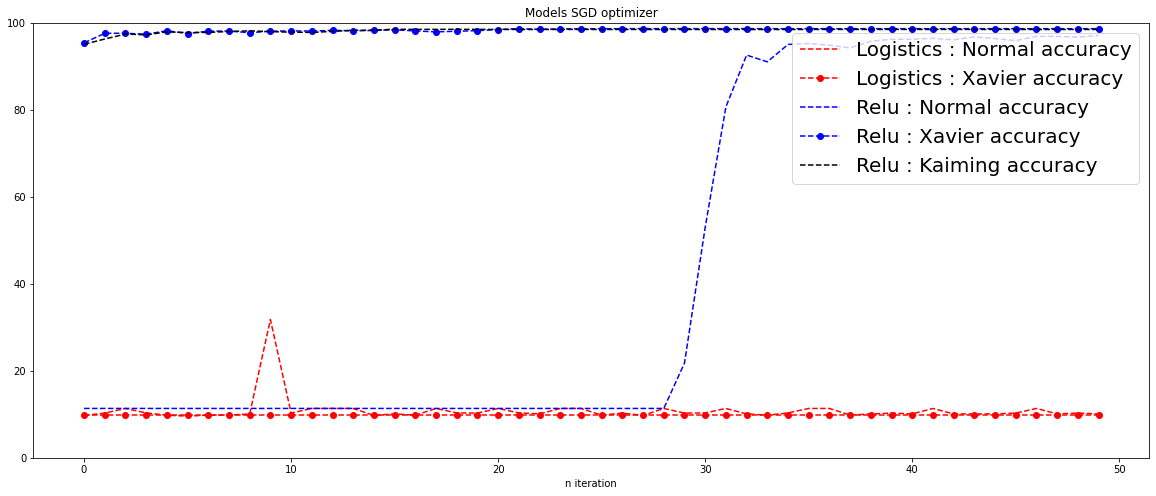

In [54]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
def draw_result(lst_iter, ln_acc, lx_acc , rn_acc , rx_acc , rk_acc , title):

    plt.plot(lst_iter, ln_acc, 'r--', label='Logistics : Normal accuracy')
    plt.plot(lst_iter, lx_acc, 'ro--', label='Logistics : Xavier accuracy')
    plt.plot(lst_iter, rn_acc, 'b--', label='Relu : Normal accuracy')
    plt.plot(lst_iter, rx_acc, 'bo--', label='Relu : Xavier accuracy')
    plt.plot(lst_iter, rk_acc, 'k--', label='Relu : Kaiming accuracy')

    plt.xlabel("n iteration")
    plt.ylim(0,100)
    plt.legend(loc=1, prop={'size': 20})
    plt.title(title)

    # show
    plt.show()


lst_iter = range(50)
draw_result(lst_iter ,test_SGD_accuracy , model2_SGD_accuracy ,model3_SGD_accuracy , model4_SGD_accuracy, model5_SGD_accuracy , "Models SGD optimizer" )

<Figure size 1440x576 with 0 Axes>

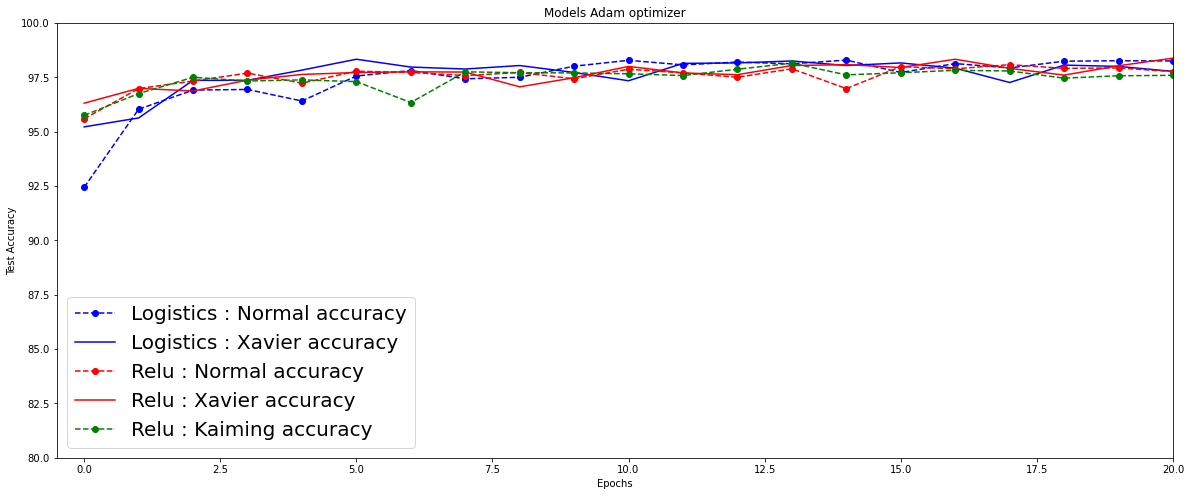

In [56]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
fig = plt.figure(figsize=(20,8))
def draw_result(lst_iter, ln_acc, lx_acc , rn_acc , rx_acc , rk_acc , title):

    plt.plot(lst_iter, ln_acc, 'bo--', label='Logistics : Normal accuracy')
    plt.plot(lst_iter, lx_acc, 'b', label='Logistics : Xavier accuracy')
    plt.plot(lst_iter, rn_acc, 'ro--', label='Relu : Normal accuracy')
    plt.plot(lst_iter, rx_acc, 'r', label='Relu : Xavier accuracy')
    plt.plot(lst_iter, rk_acc, 'go--', label='Relu : Kaiming accuracy')

    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy")
    
    plt.ylim(80,100)
    plt.xlim(-0.5,20)
    plt.legend(loc=3, prop={'size': 20})
    plt.title(title)

    # show
    plt.show()
lst_iter = range(50)
draw_result(lst_iter ,test_ADAM_accuracy , model2_ADAM_accuracy ,model3_ADAM_accuracy , model4_ADAM_accuracy, model5_ADAM_accuracy , "Models Adam optimizer" )